# Stress state within a prestine ground glacier.


In this code, we'll gain insight into the behaviour of pristine glaciers that are land terminating and ocean terminating. Mimicking the conditions relevant to grounded glaciers, a free slip condition is applied to the bottom surface, restraining the displacement in the vertical direction. The normal component of the displacement field at the far left edge is restrained to prevent rigid body motion in the horizontal direction. The top surface, representing the atmosphere–ice interface, is defined as a free boundary.


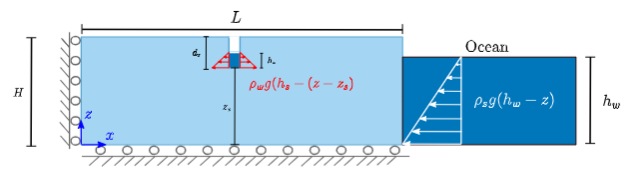


In [34]:
## Step 1: Preprocessing
# - Define units: N, m
# - Prepare the design basis report
## Step 2: Importing Necessary Libraries
from dolfin import *
import ufl
from helpers import *
from problem_definition import *
from matplotlib import pyplot as plt

# Set log level 
set_log_level(LogLevel.ERROR)

%matplotlib inline
## Step 3: Loading the Mesh
mesh = Mesh()
with XDMFFile("mesh/ice-ad.xdmf") as infile:
    infile.read(mesh)
mesh.hmin()


2.332896426585406

In [35]:
# Step 4: Preparing output file
xdmf = XDMFFile("output/solution-adaptive.xdmf")
xdmf.parameters["functions_share_mesh"] = True
xdmf.parameters["rewrite_function_mesh"] = True
xdmf.parameters["flush_output"] = True

In [36]:
def get_crack_tip_coord(dmg,D1, damage_threshold=0.99):
    dmg_dg_1 = project(dmg, D1)
    y_co_ord = Function(D1, name="y_co_ord")
    y_co_ord.interpolate(Expression("x[1]", degree=1))
    coord_vec = y_co_ord.vector()[dmg_dg_1.vector()[:] >= damage_threshold]
    coord = 115  # ToDo: Change this
    if coord_vec.size > 0:
        coord = coord_vec.min()
    return coord

In [37]:
def problem(mesh, time_total=100, ms_iterations=1, p_adaptive=None, cdf_adaptive = None):
    # Step 5: Preparing the sets
    support_left = CompiledSubDomain(
        "on_boundary && near(x[0], 0.0, tol)", tol=1e-14)
    support_bottom = CompiledSubDomain(
        "on_boundary && near(x[1],0.0, tol)", tol=1e-14)
    load_right = CompiledSubDomain("on_boundary && x[1]<= 62.5 && x[0]==500")

    mf_line = MeshFunction("size_t", mesh, 1)
    load_right.mark(mf_line, 1)

    ds = Measure("ds")(subdomain_data=mf_line)

    # Step 6: Defining  spaces
    V1 = VectorFunctionSpace(mesh, "CG", 1)
    F1 = FunctionSpace(mesh, "CG", 1)
    D1 = FunctionSpace(mesh, "DG", 1)

    FDG0 = FunctionSpace(mesh, "DG", 0)
    TDG0 = TensorFunctionSpace(mesh, "DG", 0)
    # Step 7: Define functions
    u, v = TrialFunction(V1), TestFunction(V1)
    unew, uold = Function(V1, name="disp"), Function(V1, name="disp")
    stress_xx, cdf = Function(F1, name="sigma_xx"), Function(FDG0, name="cdf")
    p, q = TrialFunction(F1), TestFunction(F1)

    pnew, pold = Function(F1, name="damage"), Function(F1, name="damage")
  
    if p_adaptive is not None:
        pold.assign(project(p_adaptive, F1))
        pnew.assign(project(p_adaptive, F1))
    if cdf_adaptive is not None:
        cdf.assign(project(cdf_adaptive, FDG0))
    # Step 8: Material Model
    # N, m, Pa
    g = 9.81
    rho_sea = 1020
    E0_ice = 9500e6
    nu_ice = 0.35
    rho_i_ice = 917
    sigma_c_ice = 4*0.1185e6
    l = 0.625
    ice = MaterialModel(E0_ice, nu_ice, rho_i_ice, sigma_c_ice, 1)
    # Step 9: Define supports
    bc_sp_x = DirichletBC(V1.sub(0), Constant(0.0), support_left)
    bc_sp_x2 = DirichletBC(V1.sub(1), Constant(0.0), support_bottom)
    bc_u = [bc_sp_x, bc_sp_x2]
    # Step 10: Define Loads
    t = Expression(
        ("-(rho_sea*(125/2 -x[1]))", 0), rho_sea=rho_sea*g, degree=1)
    # t = Constant((0, 0))
    f = Constant((0, -ice.rho * g))
    # Step 11: Define the problem
    a_disp = inner(degradation(pold) * ice.stress(u), ice.strain(v)) * dx
    step_fun = conditional(gt(pold, 0.001), 0.0, 1.0)
    L_disp = step_fun * dot(f, v) * dx + dot(t, v) * ds(1)
    a_phase = ((1 + cdf) * inner(p, q) + l**2 * inner(grad(p), grad(q))) * dx
    L_phase = inner(cdf, q) * dx
    # Step 12: Solve
    disp_problem = LinearVariationalProblem(a_disp, L_disp, unew, bc_u)
    phase_problem = LinearVariationalProblem(a_phase, L_phase, pnew)
    problem = FractureProblem(disp_problem, phase_problem, ice, cdf, cdf_adaptive)
    solver = FractureSolver(problem)
    prm = solver.parameters
    prm["time_start"] = 0.0
    prm["time_total"] = time_total
    prm["delta_t"] = 1.0
    prm["multi_staggered"]["tolerance"] = 1e-5
    prm["multi_staggered"]["maximum_iterations"] = ms_iterations
    solver.solve()

    cracktip_coor = get_crack_tip_coord(pnew,D1)
    H = 125
    depth_ratio = 1 - cracktip_coor / H


    print(f"Crack tip coordinate: {cracktip_coor}, Depth ratio: {depth_ratio}")

    return pnew, cdf

In [38]:
def get_markers(_phi, mesh, target_hmin):
    adaptivity_converged = False

    marker = MeshFunction("bool", mesh, mesh.topology().dim())
    marker.set_all(False)

    DG = FunctionSpace(mesh, "DG", 0)
    phi= project(_phi, DG)
    marker.array()[phi.vector()[:] > 0.1] = True
    # ---------------------------------------------------------------------------------
    # Scheme S4    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    cell_dia = Circumradius(mesh)
    dia_vector = project(cell_dia, DG, solver_type="cg",
                         preconditioner_type="hypre_euclid").vector()[:]
    marker.array()[dia_vector < target_hmin] = False
    # ---------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------
    DG = None
    del DG

    adaptivity_converged = np.all(np.invert(marker.array()))
    return marker, adaptivity_converged

step:   0.0, dof:      1740, hmin:  2.33 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      1761, hmin:  1.28 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      1821, hmin:  0.64 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      1953, hmin:  0.32 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996


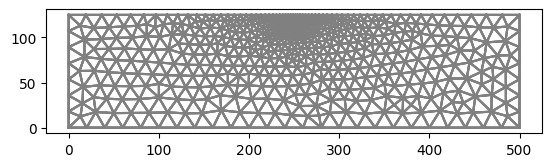

In [39]:
adaptivity_converged = False

while not adaptivity_converged:
    pold,cdf_old = problem(mesh, 0.0, 1)
    marker, adaptivity_converged = get_markers(pold, mesh, target_hmin=0.3)
    # print(adaptivity_converged)
    mesh = refine(mesh, marker)
    plot(mesh)

In [40]:
mesh.hmin(), mesh.num_cells(), mesh.num_vertices()

(0.3204763045491232, 1185, 651)

In [41]:
pold.vector()[:].shape

(651,)

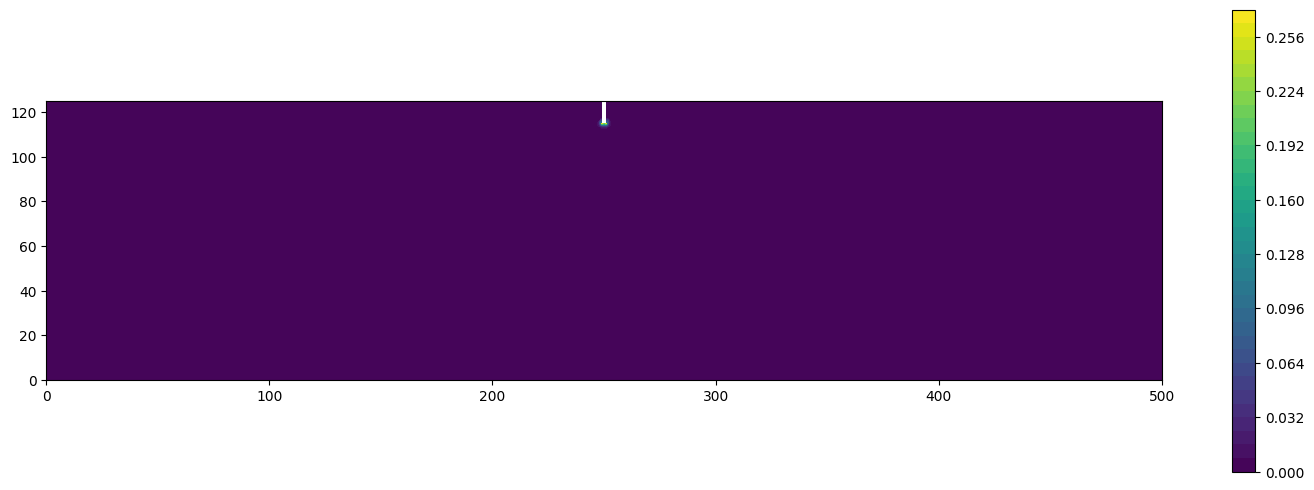

In [42]:
plt.figure(figsize=(18, 6))
c = plot(pold)
plt.colorbar(c)  # Adds the colorbar
plt.show()

In [43]:
xdmf.write(pold, 0)

In [44]:
cpp_code = """
#include <pybind11/pybind11.h>
#include <dolfin/adaptivity/adapt.h>
#include <dolfin/function/Function.h>
#include <dolfin/mesh/Mesh.h>
namespace py = pybind11;
PYBIND11_MODULE(SIGNATURE, m)
{
m.def("adapt", [](const dolfin::Function &function,
          std::shared_ptr<const dolfin::Mesh> adapted_mesh,
                  bool interpolate){
             return dolfin::adapt(function, adapted_mesh, interpolate);});
}
"""
m = compile_cpp_code(cpp_code)


def adaptFunction(f, mesh, interp=True):
    return m.adapt(f, mesh, interp)


def transfer(_p, mesh):
    _p = Function(adaptFunction(_p._cpp_object, mesh))
    return _p

In [45]:
p_adaptive_n = pold
cdf_adaptive_n = cdf_old


for i in range(100):
    adaptivity_converged = False
    while not adaptivity_converged:
        p_adaptive_n_1, cdf_adaptive_n_1 = problem(mesh, 0.0, 1, p_adaptive_n, cdf_adaptive_n)
        marker, adaptivity_converged = get_markers(
            p_adaptive_n_1, mesh, target_hmin=0.3)
        # print(adaptivity_converged)
        mesh = refine(mesh, marker)
        p_adaptive_n = transfer(p_adaptive_n, mesh)
        cdf_adaptive_n = transfer(cdf_adaptive_n, mesh)

    p_adaptive_n.assign(p_adaptive_n_1)
    cdf_adaptive_n.assign(cdf_adaptive_n_1)
    p_adaptive_n.rename("damage", "damage")
    xdmf.write(p_adaptive_n, i+1)

step:   0.0, dof:      1953, hmin:  0.32 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      2097, hmin:  0.16 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      2193, hmin:  0.16 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      2220, hmin:  0.16 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      2220, hmin:  0.16 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      2259, hmin:  0.16 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      2259, hmin:  0.16 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      2307, hmin:  0.16 time:      0
Crack tip coordinate: 115, Depth ratio: 0.07999999999999996
step:   0.0, dof:      2307, hmin:  0.16 time:      0
Crack tip coordinate: 115, Depth r

In [46]:
mesh.hmin(), mesh.num_cells()

(0.16023815227456045, 6032)

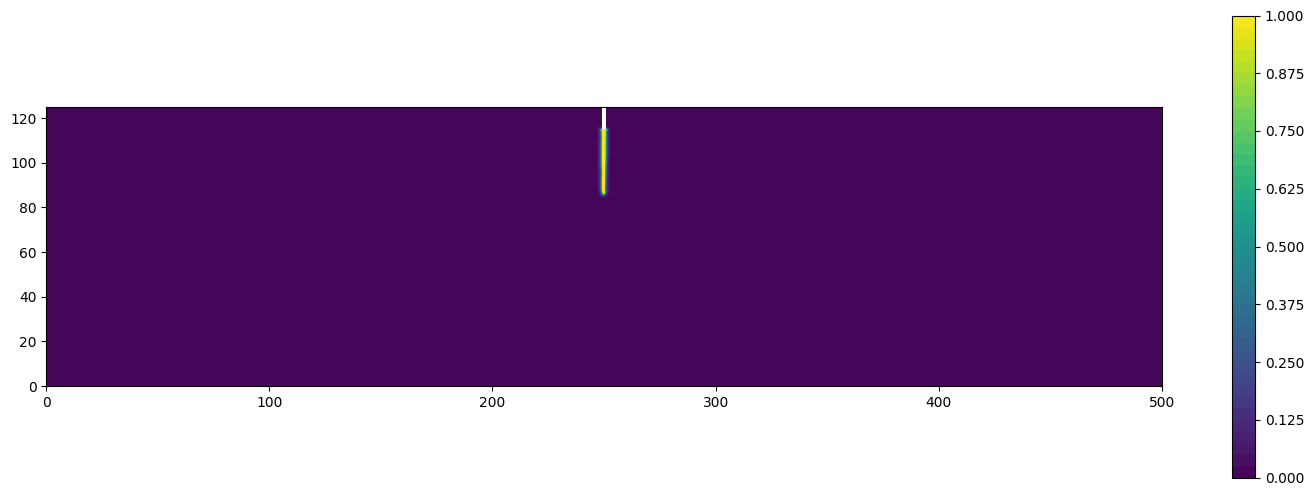

In [47]:
plt.figure(figsize=(18, 6))
c = plot(p_adaptive_n)
plt.colorbar(c)  # Adds the colorbar
plt.show()

In [48]:
with XDMFFile("output/output.xdmf") as outfile:
    outfile.write(p_adaptive_n, 0)
